<a href="https://colab.research.google.com/github/BrianBolivar/Deep-Learning-for-AI/blob/main/Flowers_and_Birds_Classification_DL_for_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flowers and Birds Classification

## Description of Datasets

The datasets are provided from Kaggle:


*   [Flower Classification | 10 Classes](https://www.kaggle.com/datasets/utkarshsaxenadn/flower-classification-5-classes-roselilyetc): it containts 3 folders, training, validation and testing respectively; each folder contains 10 folders with types of flowers, 1500 images for each flower for training and 500 for validation, for testing the dataset does not provide a costant number of images of each flower.


*   [Birds 500 Species- Image Classification](https://www.kaggle.com/datasets/gpiosenka/100-bird-species): it contains 3 folders, training, validation and testing respectively; each folder contains 500 folders with types of birds, the dataset does not provide a constant number of images for each type of bird; It also contain a .csv file with: "id", "filepaths", "labels", "data set" and "scientific name". The high number of classes and its unbalanced number of images for bird takes us to reduce the number of classes and takes classes with a sufficient and reasonable number of images for class.

The main goal of our project is to build a model that can classify images with high accuracy, allowing us to automate and streamline the process of categorizing images.

## Packages for project

In [ ]:
import os
import shutil
import torchvision
import re, sys, json, cv2, random
from tqdm import tqdm #for progress bar visualisation
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import seaborn as sns
!pip install d2l==1.0.0a1.post0  # notice the precise version
from d2l import torch as d2l
import torch
from torch import nn
import torch.utils.data as data
from torch.nn import functional as F
from sklearn.model_selection import KFold
import random
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
!pip install torchviz
from torchviz import make_dot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Flower Classification

We selected 600 images per class for our deep learning task due to the fact that using the entire dataset of 1500 images per class would result in a very large dataset, which could cause issues with computational resources and model training time. By selecting a smaller subset of images, we can still obtain representative samples while also making it feasible to perform k-fold cross-validation and learning rate tuning efficiently.

## Preparing Dataframe for Training

In [ ]:
# Set the path of the original dataset directory
original_dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/archive/Flower Classification V2/V2/Training Data'

# Set the path of the new dataset directory
new_dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/1000_Flowers'

# Set the number of images to use per class
num_images_per_class = 600

# Set the random seed
random_seed = 42

# Check if the new dataset directory already exists
if os.path.exists(new_dataset_dir):
    print('The new dataset directory already exists. Skipping creation.')
else:
  # Loop through each class directory in the original dataset directory
  for class_name in os.listdir(original_dataset_dir):

      # Create a new directory for the class in the new dataset directory
      os.makedirs(os.path.join(new_dataset_dir, class_name), exist_ok=True)

      # Get a list of all the image filenames in the class directory
      all_image_filenames = os.listdir(os.path.join(original_dataset_dir, class_name))

      # Set the random seed
      random.seed(random_seed)

      # Shuffle the list of image filenames
      random.shuffle(all_image_filenames)

      # Loop through the first num_images_per_class images in the shuffled list
      for i, filename in enumerate(all_image_filenames):
          if i >= num_images_per_class:
              break

          # Copy the image to the corresponding new directory
          shutil.copy(os.path.join(original_dataset_dir, class_name, filename),
                      os.path.join(new_dataset_dir, class_name, filename))


The new dataset directory already exists. Skipping creation.


In [ ]:
root_training = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/1000_Flowers'
flowers_dirs = os.listdir(root_training)

In [ ]:
#Create a list of flowers' types
classes = [cla for cla in os.listdir(root_training) if os.path.isdir(os.path.join(root_training, cla))]
print(classes)

['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']


In [ ]:
#Create a dictionary containing flowers' type and their number class
class_indices = {k: v for v, k in enumerate(classes)}
class_indices

{'Aster': 0,
 'Daisy': 1,
 'Iris': 2,
 'Lavender': 3,
 'Lily': 4,
 'Marigold': 5,
 'Orchid': 6,
 'Poppy': 7,
 'Rose': 8,
 'Sunflower': 9}

In [ ]:
#Create a json file containg flowers' type
json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)
with open('classes_indices_training.json', 'w') as json_file:
    json_file.write(json_str)

In [ ]:
every_class_num = []
supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

# Lists containg information of paths, labels and bad images for Training
filepaths = []
labels = []
bad_images = []
for klass in classes:
  classpath = os.path.join(root_training, klass)
  images = [os.path.join(root_training, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
  every_class_num.append(len(images))
  flist = sorted(os.listdir(classpath))
  desc = f'{klass:23s}'
  for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(classpath, f)
      fl = f.lower()
      index = fl.rfind('.')
      ext = fl[index:]
      if ext in supported:
          image = Image.open(fpath)
          if image.mode == 'RGB':
              try:
                  img = cv2.imread(fpath)
                  filepaths.append(fpath)
                  labels.append(klass)
              except:
                  bad_images.append(fpath)
                  print('defective image file: ', fpath)
      else:
          bad_images.append(fpath)

Sunflower              : 100%|████████████████████████████████████████████| 600/600 [00:08<00:00, 67.09file/s]


In [ ]:
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(f'{len(df.labels.unique())} kind of images were found in the dataset')

10 kind of images were found in the dataset


In [ ]:
train_image_path = df['filepaths'].tolist()
train_image_label = [class_indices[i] for i in df['labels'].tolist()]

sample_df = df.sample(n=50, replace=False)

ht, wt, count = 0, 0, 0
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
        img = cv2.imread(fpath)
        h = img.shape[0]
        w = img.shape[1]
        ht += h
        wt += w
        count += 1
    except:
        pass
have = int(ht / count)
wave = int(wt / count)
aspect_ratio = have / wave
print('{} images were found in the dataset.\n{} for training'.format(
    sum(every_class_num), len(train_image_path)
))
print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

6000 images were found in the dataset.
5998 for training
average image height=  202   average image width=  248  aspect ratio h/w=  0.8145161290322581


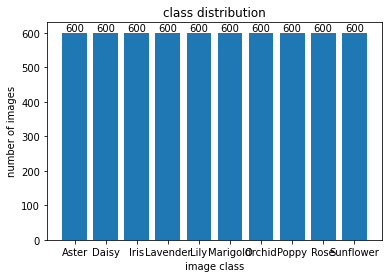

In [ ]:
plt.bar(range(len(classes)), every_class_num, align='center')
plt.xticks(range(len(classes)), classes)

for i, v in enumerate(every_class_num):
    plt.text(x=i, y=v + 5, s=str(v), ha='center')

plt.xlabel('image class')
plt.ylabel('number of images')

plt.title('class distribution')
plt.show()

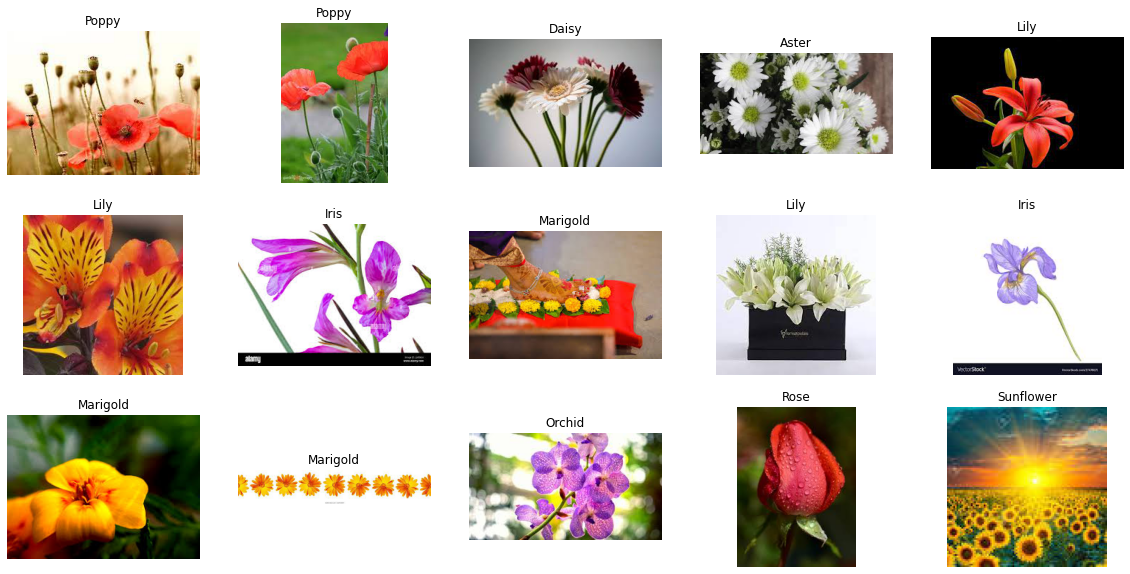

In [ ]:
# Randomly select 15 rows from the dataframe
selected_rows = df.sample(n=15, random_state=29)

# Create a Matplotlib figure with 5 subplots
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

# Loop over the selected rows and display each image in a subplot
n=0
for i, row in selected_rows.iterrows():
    img = plt.imread(row['filepaths'])
    ax = axs[n // 5, n % 5]
    ax.imshow(img)
    ax.set_title(row['labels'])
    ax.axis('off')
    n+=1
    if n ==15:
      break

# Show the figure
plt.show()

### MyDataset

In [ ]:
class MyDataset(Dataset):
  def __init__(self, image_path, image_labels, transforms=None):
      self.image_path = image_path
      self.image_labels = image_labels
      self.transforms = transforms

  def __len__(self):
      return len(self.image_path)

  def __getitem__(self, idx):
      image = Image.open(self.image_path[idx])
      if image.mode != 'RGB':
          raise ValueError(f'image: {self.image_path[idx]} is not a RGB image!')
      label = self.image_labels[idx]
      if self.transforms is not None:
          image = self.transforms(image)
      return image, label

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data augmentation
Data augmentation techniques can be used to increase the size of the dataset and improve the performance of the model.
*   Random Crop: Randomly crop the image to a smaller size to simulate the presence of different views of the same flower.
*   Horizontal Flip: Flip the image horizontally to simulate the presence of mirror images of the flower.
*   Random Rotation: Rotate the image by a random angle to simulate the presence of flowers in different orientations.
*   Random Brightness and Contrast: Adjust the brightness and contrast of the image by a random factor to simulate the presence of flowers under different lighting conditions.
*   Color Jitter: Randomly adjust the hue, saturation, and brightness of the image to simulate the presence of flowers with different colors.









#### Find mean and standard deviation for Normalisation

In [ ]:
def get_mean_std(loader):
  mean = 0.
  std = 0.
  tot_img_count = 0
  for img, _ in loader:
    img_count_in_batch = img.size(0)
    img = img.view(img_count_in_batch, img.size(1), -1)
    mean += img.mean(2).sum(0)
    std += img.std(2).sum(0)
    tot_img_count += img_count_in_batch

  mean /= tot_img_count
  std /= tot_img_count
  return mean,std

In [ ]:
batch_size = 32

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_1'])
train_loader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=batch_size)

In [ ]:
mean, std = get_mean_std(train_loader)

In [ ]:
def show_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=15, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow = 5)
  plt.figure(figsize= (11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print('labels:',labels)

In [ ]:
norm_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])


norm_train_dataset = ImageFolder(root_training, transform=norm_image_transforms)

norm_train_dataloader = data.DataLoader(norm_train_dataset,batch_size=batch_size,shuffle=True)

labels: tensor([0, 2, 4, 5, 8, 4, 9, 3, 7, 7, 4, 3, 8, 8, 3])


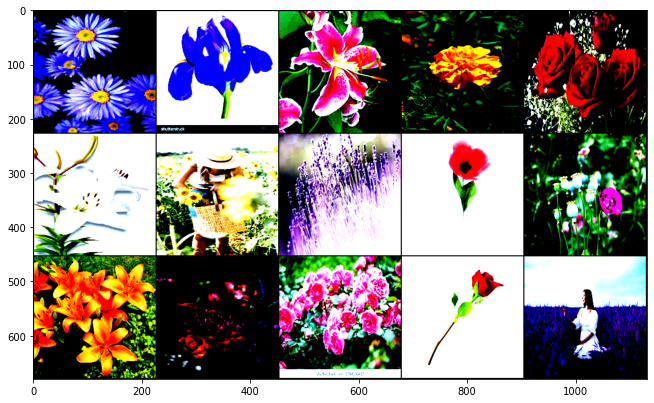

In [ ]:
show_images(norm_train_dataset)

In [ ]:
print(torch.Tensor(mean), torch.Tensor(std))

tensor([0.4137, 0.3755, 0.3324]) tensor([0.3250, 0.2993, 0.2924])


#### Data augmentation techniques

In [ ]:
# Define data transforms
data_transforms = {
    'train_1': transforms.Compose([
        transforms.CenterCrop(256),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
    ]),
    'train_2': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
    ]),
    'train_3': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        #transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.4137, 0.3755, 0.3324], [0.3250, 0.2993, 0.2924]),
    ]),
    'train_4': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.9),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
    ]),
    'train_5': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(60),
        transforms.ColorJitter(brightness=0.9, contrast=0.5, saturation=0.5, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.4137, 0.3755, 0.3324], [0.3250, 0.2993, 0.2924]),
    ]),
    'train_6': transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.1, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        #transforms.GaussianBlur(kernel_size=3),
        #transforms.RandomErasing(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4137, 0.3755, 0.3324], [0.3250, 0.2993, 0.2924]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4137, 0.3755, 0.3324], [0.3250, 0.2993, 0.2924])
    ])
}

#### Visualise data augmentation applied in an image

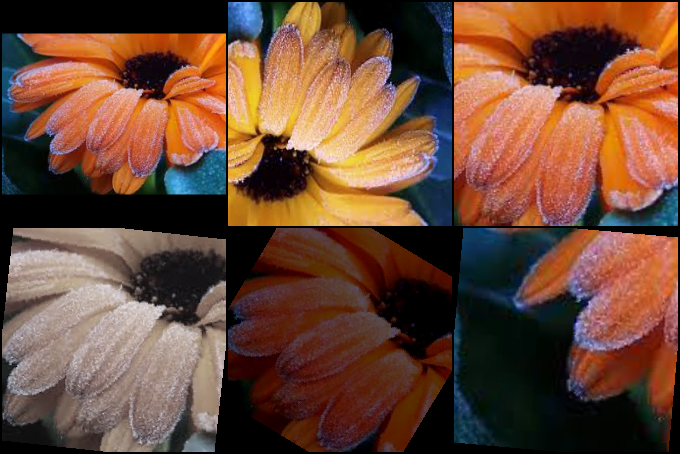

In [ ]:
# Load an image
img_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/1000_Flowers/Marigold/Marigold-Train (151).jpeg'
img = Image.open(img_path)

# Create a list of transformed images
transformed_imgs = []
for i in range(1, 7):
    transform = data_transforms[f'train_{i}']
    transformed_img = transform(img)
    transformed_imgs.append(transformed_img)

# Combine the transformed images into a grid and display
grid = make_grid(transformed_imgs, nrow=3)
TF.to_pil_image(grid).show()

In [ ]:
batch_size = 32

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_1'])
train_loader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=batch_size)
train_num = len(train_dataset)

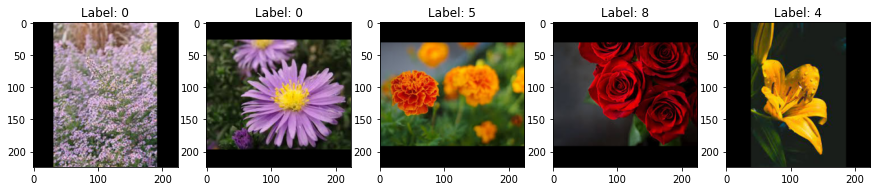

In [ ]:
# Get a batch of images from the DataLoader
images, labels = next(iter(train_loader))

# Display the first 5 images from the batch
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(images[i].permute(1, 2, 0))
    ax[i].set_title(f"Label: {labels[i]}")
plt.show()

## Deep Neural Network

For our project, we will use the GoogleNet and ResNet-18 architectures to train our deep learning models and achieve high accuracy on our tasks.

For each structure we:

*   **Perform learning rate tuning**: this involves selecting an optimal learning rate for the model by training it with a range of learning rates and selecting the one that results in the best performance

*   **Apply data augmentation**: this involves using various techniques to create new training examples by randomly transforming the original images, such as flipping, rotating, or cropping them.

*   **Generate a confusion matrix**: this involves computing the number of true positives, false positives, true negatives, and false negatives for each class in the test set and organizing the results in a matrix to evaluate the model's performance.



### Some function we will use

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr,
          device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in tqdm(range(num_epochs), desc='Training', colour='blue'):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
        test_acc = evaluate_accuracy_gpu(net, test_iter)

In [ ]:
def k_fold_cross_validation(dataset, model, lr, num_epochs, batch_size, k=5):
    # Create a KFold object
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Initialize an empty list to store the accuracy scores
    accuracy_scores = []

    # Loop through the folds
    for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
        # Get the training and validation data for this fold
        train_data = torch.utils.data.Subset(dataset, train_indices)
        val_data = torch.utils.data.Subset(dataset, val_indices)

        # Create the data loaders for the training and validation data
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

        train(model, train_loader, val_loader, num_epochs, lr, device=d2l.try_gpu())

        # Evaluate the model on the validation data
        accuracy = evaluate_accuracy_gpu(model, val_loader, device=None)

        # Print the accuracy for this fold
        print('Fold [{}/{}]: Accuracy = {:.2f}%'.format(fold+1, k, accuracy*100))

        # Add the accuracy score to the list of accuracy scores
        accuracy_scores.append(accuracy)

    # Calculate the average accuracy score
    average_accuracy = sum(accuracy_scores) / len(accuracy_scores)

    # Print the average accuracy score
    print('Average Accuracy = {:.2f}%'.format(average_accuracy*100))
    return accuracy_scores

In [ ]:
def train_animated(net, train_iter, test_iter, num_epochs, lr,
          device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in tqdm(range(num_epochs), desc='Training', colour='blue'):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, test acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

### GoogleNet

One of the key innovations in GoogleNet was the use of the Inception module, which is a multi-branch convolutional neural network module designed to efficiently capture both local and global information within an image. The Inception module uses multiple filter sizes (1x1, 3x3, and 5x5) in parallel, as well as pooling operations, to extract features at different scales.

Another important aspect of GoogleNet is its use of a 1x1 convolutional layer, which is used to perform dimensionality reduction before passing the features through the larger convolutional layers. This helps to reduce the number of parameters in the model and improve its computational efficiency.

#### Create the Neural Network

In [ ]:
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): #192, 64, (96, 128), (16, 32), 32)
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)), # The argument (1,1) is the required OUTPUT shape
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10)) # For others dataset need to change the 10

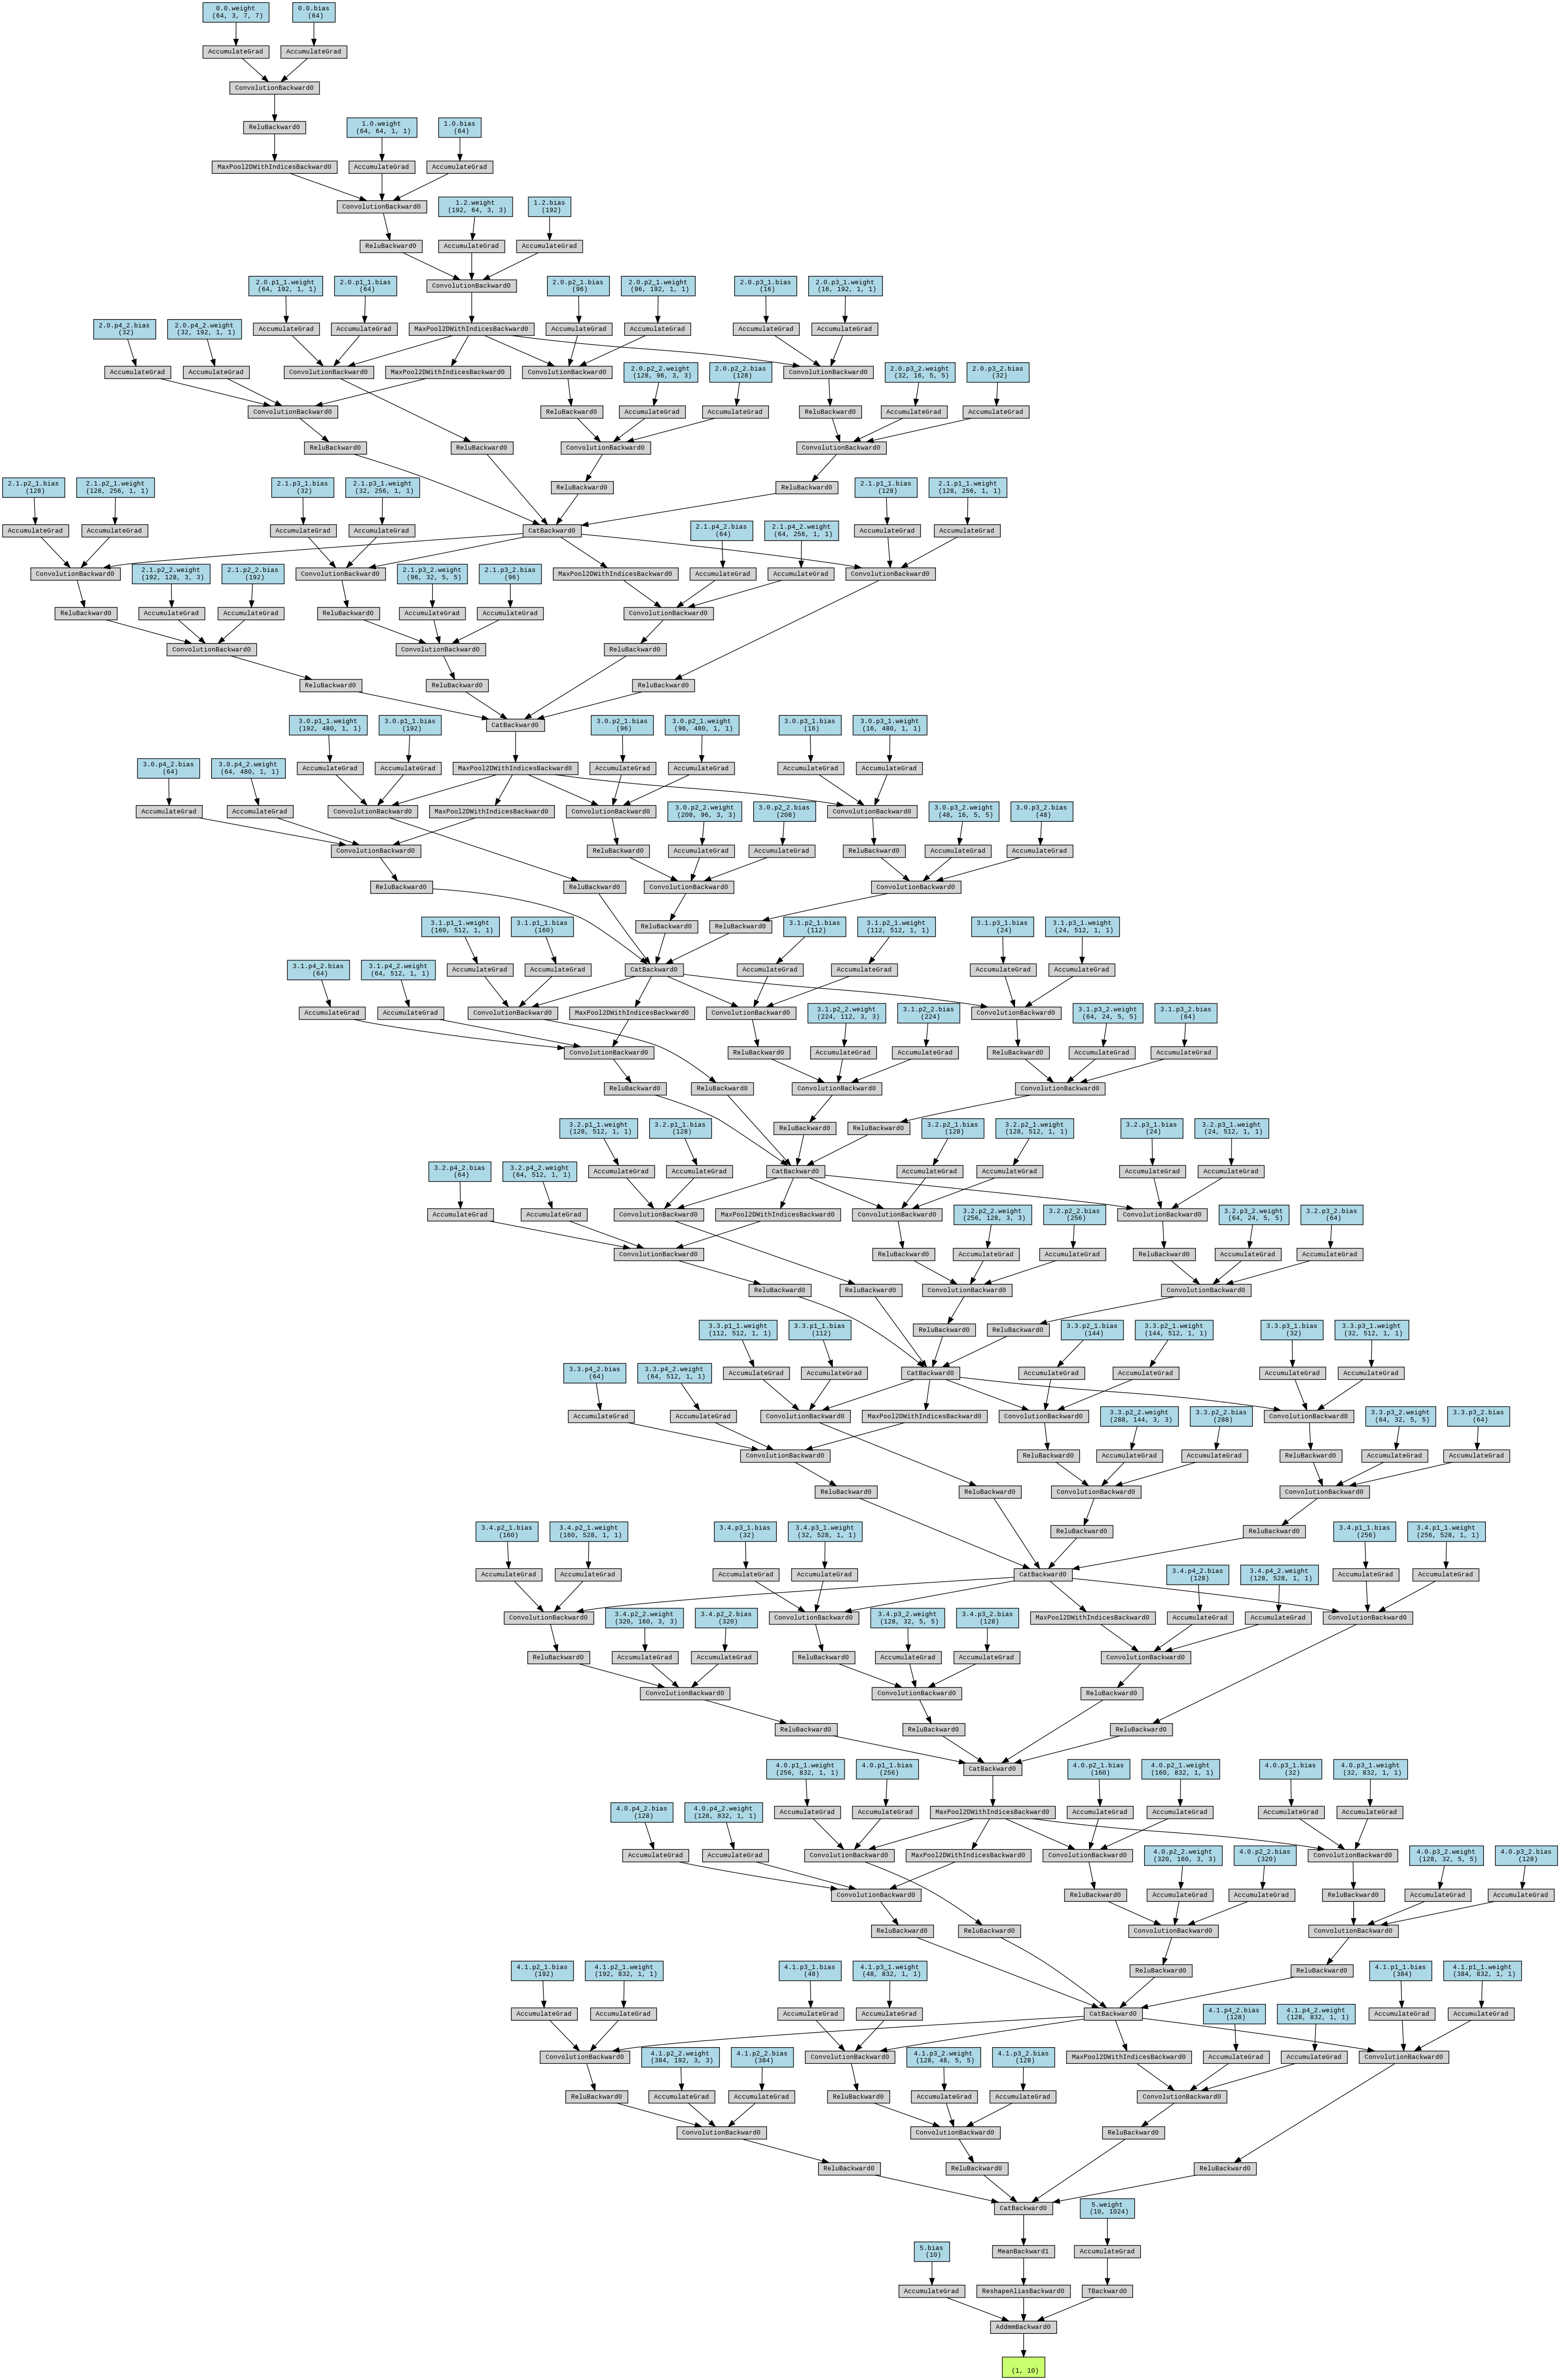

In [ ]:
from IPython.display import Image
# Create a dummy input tensor
x = torch.randn(1, 3, 224, 224)

# Generate a graph of the model's architecture
dot = make_dot(net(x), params=dict(net.named_parameters()))

# Save the graph to a file
dot.render('net', format='png')
# Display the graph image
Image(filename='net.png')

#### Tuning the Learning Rate

Tuning the learning rate is an important step in deep learning to ensure that the model converges quickly and effectively during training. The learning rate is a hyperparameter that determines how much the model should adjust its weights during training. It determines the size of the step that the optimizer takes at each iteration while searching for the optimal weights.

We star with 5 values for learning rate, respectively **7e-5, 5e-5, 3e-5, 1e-5** and peferm GoogleNet in K-Fold with:


*   num_epochs = 2
*   batch_size = 8
*   k = 5



In [ ]:
list_lr = [7e-5, 5e-5, 3e-5, 1e-5]
for i in list_lr:
  print('-------------------\n')
  print('Learning rate = {}'.format(i))
  k_fold_cross_validation(train_dataset, net, i, num_epochs=2, batch_size=8, k=5)

-------------------

Learning rate = 7e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:32<00:00, 46.36s/it]


Fold [1/5]: Accuracy = 41.50%
training on cuda:0


Training: 100%|██████████| 2/2 [01:33<00:00, 46.55s/it]


Fold [2/5]: Accuracy = 41.08%
training on cuda:0


Training: 100%|██████████| 2/2 [01:32<00:00, 46.13s/it]


Fold [3/5]: Accuracy = 42.92%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.55s/it]


Fold [4/5]: Accuracy = 42.79%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.62s/it]


Fold [5/5]: Accuracy = 45.79%
Average Accuracy = 42.81%
-------------------

Learning rate = 5e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.60s/it]


Fold [1/5]: Accuracy = 46.67%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.60s/it]


Fold [2/5]: Accuracy = 41.42%
training on cuda:0


Training: 100%|██████████| 2/2 [01:30<00:00, 45.25s/it]


Fold [3/5]: Accuracy = 37.17%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.87s/it]


Fold [4/5]: Accuracy = 41.95%
training on cuda:0


Training: 100%|██████████| 2/2 [01:30<00:00, 45.20s/it]


Fold [5/5]: Accuracy = 46.04%
Average Accuracy = 42.65%
-------------------

Learning rate = 3e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.54s/it]


Fold [1/5]: Accuracy = 39.00%
training on cuda:0


Training: 100%|██████████| 2/2 [01:33<00:00, 46.89s/it]


Fold [2/5]: Accuracy = 35.25%
training on cuda:0


Training: 100%|██████████| 2/2 [01:30<00:00, 45.48s/it]


Fold [3/5]: Accuracy = 42.00%
training on cuda:0


Training: 100%|██████████| 2/2 [01:30<00:00, 45.30s/it]


Fold [4/5]: Accuracy = 39.62%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.51s/it]


Fold [5/5]: Accuracy = 41.12%
Average Accuracy = 39.40%
-------------------

Learning rate = 1e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.61s/it]


Fold [1/5]: Accuracy = 30.50%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.69s/it]


Fold [2/5]: Accuracy = 30.92%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.57s/it]


Fold [3/5]: Accuracy = 21.50%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.68s/it]


Fold [4/5]: Accuracy = 32.61%
training on cuda:0


Training: 100%|██████████| 2/2 [01:31<00:00, 45.84s/it]


Fold [5/5]: Accuracy = 36.70%
Average Accuracy = 30.44%


From the above results we can note that **learning rate** with 7e-5 and 5e-5 have similar **average accuracy**, but it's slightly high for 7e-5, for this reason we set lr = 7e-5.

### GoogleNet AvgPool

We modified the GoogLeNet model by replacing the max pooling operations with average pooling in certain blocks of the network.


#### Define the Neural Network

In [ ]:
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): #192, 64, (96, 128), (16, 32), 32)
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.AvgPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.AvgPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)), # The argument (1,1) is the required OUTPUT shape
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10)) # For others dataset need to change the 10

#### Evaluate the performace

In [ ]:
k_fold_cross_validation(train_dataset, net, 7e-5, num_epochs=2, batch_size=8, k=5)

training on cuda:0


Training: 100%|██████████| 2/2 [01:40<00:00, 50.20s/it]


Fold [1/5]: Accuracy = 29.67%
training on cuda:0


Training: 100%|██████████| 2/2 [01:33<00:00, 46.99s/it]


Fold [2/5]: Accuracy = 35.92%
training on cuda:0


Training: 100%|██████████| 2/2 [01:33<00:00, 46.61s/it]


Fold [3/5]: Accuracy = 40.67%
training on cuda:0


Training: 100%|██████████| 2/2 [01:33<00:00, 46.72s/it]


Fold [4/5]: Accuracy = 33.61%
training on cuda:0


Training: 100%|██████████| 2/2 [01:33<00:00, 46.57s/it]


Fold [5/5]: Accuracy = 41.53%
Average Accuracy = 36.28%


[0.2966666666666667,
 0.3591666666666667,
 0.4066666666666667,
 0.33611342785654713,
 0.4153461217681401]

The GoogLeNet model with max pooling achieved an average accuracy of **42.81%**, while the modified version with average pooling achieved an average accuracy of **36.28%**. The architecture with average pooling performed worse, likely due to its focus on preserving spatial resolution at the expense of capturing important features in the input.


### Import the Validation Data

In [ ]:
# Set the path of the original dataset directory
original_dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/archive/Flower Classification V2/V2/Validation Data'

# Set the path of the new dataset directory
new_dataset_dir = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/400_Flowers_Validation'

# Set the number of images to use per class
num_images_per_class = 120

# Set the random seed
random_seed = 42

# Check if the new dataset directory already exists
if os.path.exists(new_dataset_dir):
    print('The new dataset directory already exists. Skipping creation.')
else:
  # Loop through each class directory in the original dataset directory
  for class_name in os.listdir(original_dataset_dir):

      # Create a new directory for the class in the new dataset directory
      os.makedirs(os.path.join(new_dataset_dir, class_name), exist_ok=True)

      # Get a list of all the image filenames in the class directory
      all_image_filenames = os.listdir(os.path.join(original_dataset_dir, class_name))

      # Set the random seed
      random.seed(random_seed)

      # Shuffle the list of image filenames
      random.shuffle(all_image_filenames)

      # Loop through the first num_images_per_class images in the shuffled list
      for i, filename in enumerate(all_image_filenames):
          if i >= num_images_per_class:
              break

          # Copy the image to the corresponding new directory
          shutil.copy(os.path.join(original_dataset_dir, class_name, filename),
                      os.path.join(new_dataset_dir, class_name, filename))


The new dataset directory already exists. Skipping creation.


In [ ]:
root_validation = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/400_Flowers_Validation'
flowers_dirs = os.listdir(root_validation)

In [ ]:
every_class_num_val = []
supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

# Lists containg information of paths, labels and bad images for Training
filepaths_val = []
labels_val = []
bad_images_val = []
for klass in classes:
  classpath = os.path.join(root_validation, klass)
  images = [os.path.join(root_validation, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
  every_class_num_val.append(len(images))
  flist = sorted(os.listdir(classpath))
  desc = f'{klass:23s}'
  for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(classpath, f)
      fl = f.lower()
      index = fl.rfind('.')
      ext = fl[index:]
      if ext in supported:
          image = Image.open(fpath)
          if image.mode == 'RGB':
              try:
                  img = cv2.imread(fpath)
                  filepaths_val.append(fpath)
                  labels_val.append(klass)
              except:
                  bad_images_val.append(fpath)
                  print('defective image file: ', fpath)
      else:
          bad_images_val.append(fpath)

Sunflower              : 100%|████████████████████████████████████████████| 120/120 [00:02<00:00, 49.62file/s]


In [ ]:
Fseries = pd.Series(filepaths_val, name='filepaths')
Lseries = pd.Series(labels_val, name='labels')
df_validation = pd.concat([Fseries, Lseries], axis=1)
print(f'{len(df_validation.labels.unique())} kind of images were found in the dataset')

10 kind of images were found in the dataset


In [ ]:
validation_image_path = df_validation['filepaths'].tolist()
validation_image_label = [class_indices[i] for i in df_validation['labels'].tolist()]

sample_df = df_validation.sample(n=50, replace=False)

ht, wt, count = 0, 0, 0
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
        img = cv2.imread(fpath)
        h = img.shape[0]
        w = img.shape[1]
        ht += h
        wt += w
        count += 1
    except:
        pass
have = int(ht / count)
wave = int(wt / count)
aspect_ratio = have / wave
print('{} images were found in the dataset.\n{} for validation'.format(
    sum(every_class_num_val), len(validation_image_path)
))
print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

1200 images were found in the dataset.
1200 for validation
average image height=  198   average image width=  238  aspect ratio h/w=  0.8319327731092437


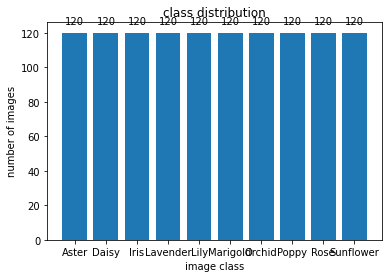

In [ ]:
plt.bar(range(len(classes)), every_class_num_val, align='center')
plt.xticks(range(len(classes)), classes)

for i, v in enumerate(every_class_num_val):
    plt.text(x=i, y=v + 5, s=str(v), ha='center')

plt.xlabel('image class')
plt.ylabel('number of images')

plt.title('class distribution')
plt.show()

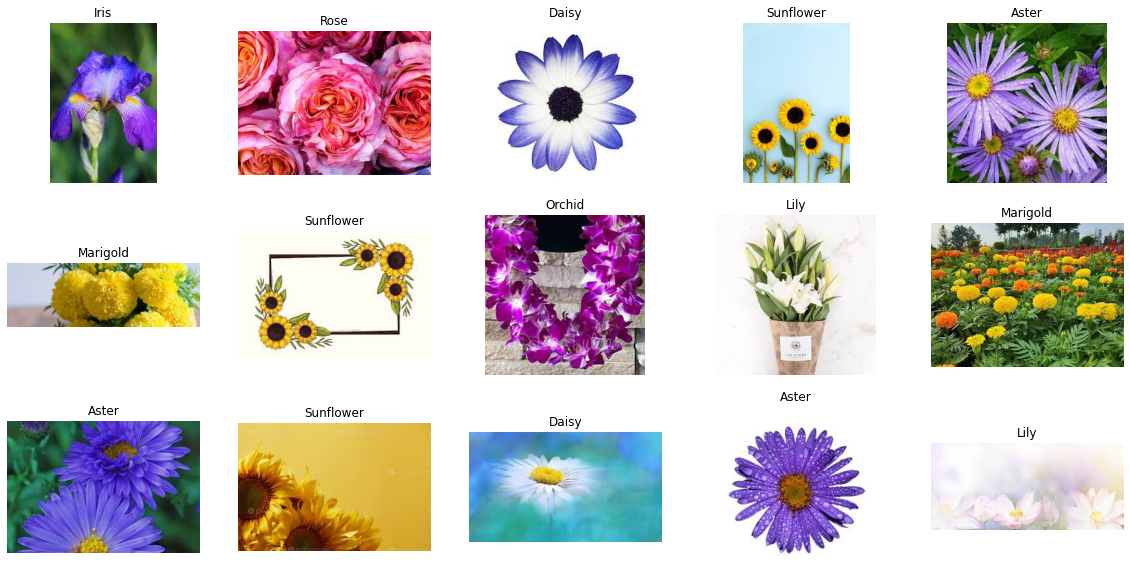

In [ ]:
# Randomly select 15 rows from the dataframe
selected_rows = df_validation.sample(n=15, random_state=34)

# Create a Matplotlib figure with 5 subplots
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

# Loop over the selected rows and display each image in a subplot
n=0
for i, row in selected_rows.iterrows():
    img = plt.imread(row['filepaths'])
    ax = axs[n // 5, n % 5]
    ax.imshow(img)
    ax.set_title(row['labels'])
    ax.axis('off')
    n+=1
    if n ==15:
      break

# Show the figure
plt.show()

### GoogleNet with Augmentation

In [ ]:
Aug = []

batch_size = 32

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_1'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_2'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_3'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_4'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_5'])
Aug.append(train_dataset)

In [ ]:
val_dataset = MyDataset(validation_image_path, validation_image_label, data_transforms['valid'])
val_loader = DataLoader(val_dataset, num_workers=0, shuffle=True, batch_size=batch_size)

In [ ]:
train_dataset_aug = torch.utils.data.ConcatDataset(Aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

Training: 100%|██████████| 15/15 [39:58<00:00, 159.91s/it]

loss 0.815, test acc 0.732, test acc 0.715
248.1 examples/sec on cuda:0


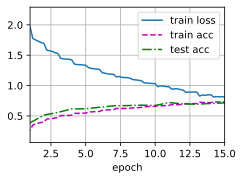

In [ ]:
train_animated(net, train_loader_aug, val_loader, num_epochs=15, lr=5e-5)

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/googlenet_flowers.pth')

Taking in account that we have used only 600 images per flower, we obtained a good peformance for the model (73.2% accuracy for validation).

We are sure that with the complete dataset we can obtain a better perfomance.

#### Confusion Matrix

##### Import Test

In [ ]:
root_testing = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/archive/Flower Classification V2/V2/Testing Data'
flowers_dirs = os.listdir(root_testing)

In [ ]:
#Create a list of flowers' types
classes = [cla for cla in os.listdir(root_testing) if os.path.isdir(os.path.join(root_testing, cla))]
print(classes)

['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']


In [ ]:
#Create a dictionary containing flowers' type and their number class
class_indices = {k: v for v, k in enumerate(classes)}
class_indices

{'Aster': 0,
 'Daisy': 1,
 'Iris': 2,
 'Lavender': 3,
 'Lily': 4,
 'Marigold': 5,
 'Orchid': 6,
 'Poppy': 7,
 'Rose': 8,
 'Sunflower': 9}

In [ ]:
#Create a json file containg flowers' type
json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)
with open('classes_indices_training.json', 'w') as json_file:
    json_file.write(json_str)

In [ ]:
every_class_num_test = []
supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

# Lists containg information of paths, labels and bad images for Testing
filepaths_test = []
labels_test = []
bad_images_test = []
for klass in classes:
  classpath = os.path.join(root_testing, klass)
  images = [os.path.join(root_testing, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
  every_class_num_test.append(len(images))
  flist = sorted(os.listdir(classpath))
  desc = f'{klass:23s}'
  for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(classpath, f)
      fl = f.lower()
      index = fl.rfind('.')
      ext = fl[index:]
      if ext in supported:
          image = Image.open(fpath)
          if image.mode == 'RGB':
              try:
                  img = cv2.imread(fpath)
                  filepaths_test.append(fpath)
                  labels_test.append(klass)
              except:
                  bad_images_test.append(fpath)
                  print('defective image file: ', fpath)
      else:
          bad_images_test.append(fpath)

Sunflower              : 100%|████████████████████████████████████████████| 328/328 [00:05<00:00, 57.53file/s]


In [ ]:
Fseries = pd.Series(filepaths_test, name='filepaths')
Lseries = pd.Series(labels_test, name='labels')
df_test = pd.concat([Fseries, Lseries], axis=1)
print(f'{len(df_test.labels.unique())} kind of images were found in the dataset')

10 kind of images were found in the dataset


In [ ]:
test_image_path = df_test['filepaths'].tolist()
test_image_label = [class_indices[i] for i in df_test['labels'].tolist()]

sample_df = df_test.sample(n=50, replace=False)

ht, wt, count = 0, 0, 0
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
        img = cv2.imread(fpath)
        h = img.shape[0]
        w = img.shape[1]
        ht += h
        wt += w
        count += 1
    except:
        pass
have = int(ht / count)
wave = int(wt / count)
aspect_ratio = have / wave
print('{} images were found in the dataset.\n{} for testing'.format(
    sum(every_class_num_test), len(test_image_path)
))
print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

2355 images were found in the dataset.
2343 for testing
average image height=  218   average image width=  231  aspect ratio h/w=  0.9437229437229437


##### Evaluate

In [ ]:
# Recall the model
import torch
# Define the path to the saved model file
model_path = "/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/googlenet_flowers.pth"

# Load the saved state dictionary into the model
model.load_state_dict(torch.load(model_path))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_print_confusion_matrix(net, data_iter, classes, device=None):
    """Compute the confusion matrix for a model on a dataset using a GPU and print it"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    y_true = []
    y_pred = []
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        y_true += y.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

    # Compute the evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    return y_true,y_pred


In [ ]:
classes = df_test.labels.unique()
classes

array(['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid',
       'Poppy', 'Rose', 'Sunflower'], dtype=object)

Accuracy: 0.7132
Precision: 0.7356
Recall: 0.7132
F1-score: 0.7155


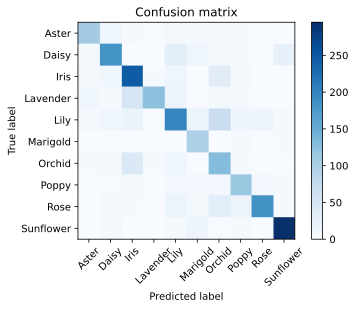

In [ ]:
test_dataset = MyDataset(test_image_path, test_image_label, data_transforms['valid'])
test_loader = DataLoader(test_dataset, num_workers=0, shuffle=True, batch_size=16)
y_true, y_pred = evaluate_and_print_confusion_matrix(net, test_loader, classes, device=None)

The model achieved an overall accuracy of 0.7132, which is a measure of how often it correctly predicted the class of the input. The precision score of 0.7356 indicates that when the model predicted a positive class, it was correct about 73.56% of the time. The recall score of 0.7132 means that the model was able to correctly identify 71.32% of the positive samples. Finally, the F1-score of 0.7155 is the harmonic mean of precision and recall, which gives a balanced measure of the model's performance.

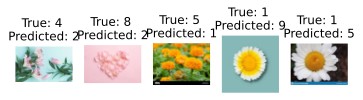

In [ ]:
# convert the lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# find the indices of incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# select a few of these images to display
num_images_to_display = 5
selected_indices = np.random.choice(incorrect_indices, num_images_to_display, replace=False)

# display the selected images
for i, index in enumerate(selected_indices):
    img = Image.open(test_image_path[index])
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.title("True: %s \nPredicted: %s" % (test_image_label[index], y_pred[index]))
    plt.axis('off')

### ResNet - 18

ResNet-18 is a deep residual neural network architecture consisting of 18 layers, including convolutional, pooling, and fully connected layers. It was introduced in 2015 by Microsoft researchers as a solution to the problem of vanishing gradients in very deep neural networks. ResNet-18 incorporates skip connections, which allow for the direct flow of information from earlier layers to later layers, enabling the network to learn more efficiently and overcome the vanishing gradients problem. These skip connections also enable the architecture to be deeper without sacrificing performance. ResNet-18 has been shown to be effective in a wide range of computer vision tasks, including image classification, object detection, and semantic segmentation.

#### Create the Neural Network

In [ ]:
# Define the ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes=25):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            ResNetBlock(64, 128, stride=2),
            ResNetBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            ResNetBlock(128, 256, stride=2),
            ResNetBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            ResNetBlock(256, 512, stride=2),
            ResNetBlock(512, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
# Define the ResNet model
resnet = ResNet(num_classes=10)

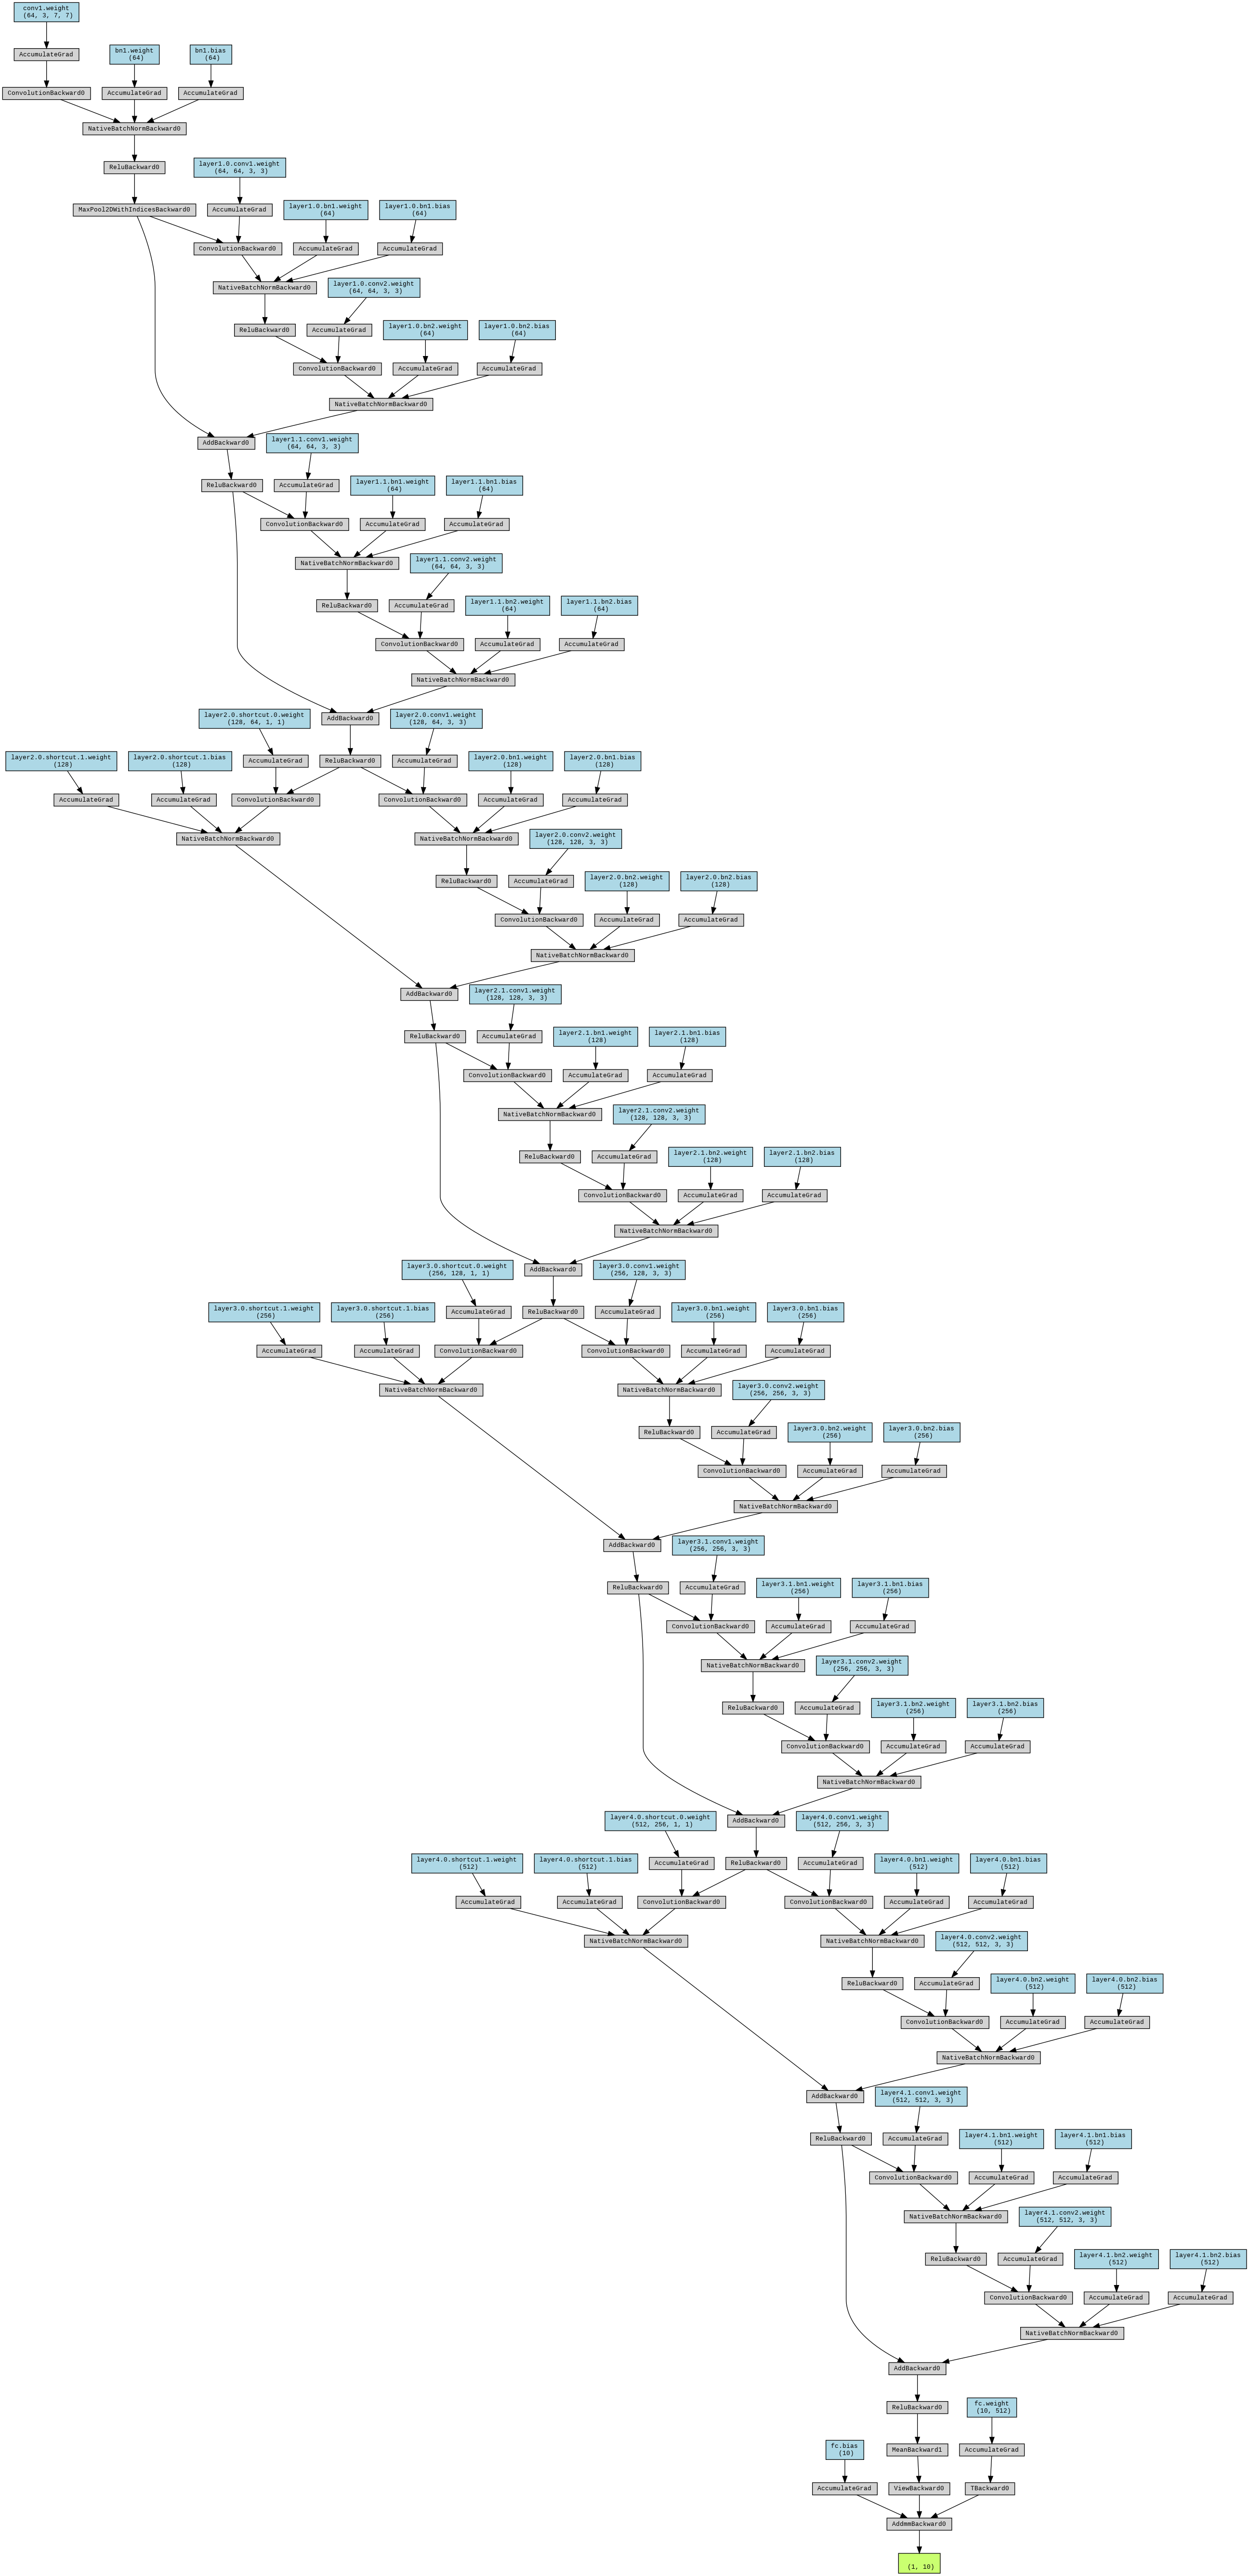

In [ ]:
# Create a dummy input tensor
x = torch.randn(1, 3, 224, 224)

# Generate a graph of the model's architecture
dot = make_dot(resnet(x), params=dict(resnet.named_parameters()))

# Save the graph to a file
dot.render('resnet', format='png')
# Display the graph image
Image(filename='resnet.png')

#### Tuning the Learning Rate

In [ ]:
list_lr = [5e-5, 3e-5, 1e-5]
for i in list_lr:
  print('-------------------\n')
  print('Learning rate = {}'.format(i))
  k_fold_cross_validation(train_dataset, resnet, i, num_epochs=2, batch_size=8, k=5)

-------------------

Learning rate = 5e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:33<00:00, 46.64s/it]


Fold [1/5]: Accuracy = 46.92%
training on cuda:0


Training: 100%|██████████| 2/2 [01:26<00:00, 43.12s/it]


Fold [2/5]: Accuracy = 54.42%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.92s/it]


Fold [3/5]: Accuracy = 53.67%
training on cuda:0


Training: 100%|██████████| 2/2 [01:26<00:00, 43.02s/it]


Fold [4/5]: Accuracy = 47.96%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.99s/it]


Fold [5/5]: Accuracy = 47.71%
Average Accuracy = 50.13%
-------------------

Learning rate = 3e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.99s/it]


Fold [1/5]: Accuracy = 46.08%
training on cuda:0


Training: 100%|██████████| 2/2 [01:26<00:00, 43.11s/it]


Fold [2/5]: Accuracy = 50.42%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.58s/it]


Fold [3/5]: Accuracy = 51.67%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.89s/it]


Fold [4/5]: Accuracy = 49.96%
training on cuda:0


Training: 100%|██████████| 2/2 [01:24<00:00, 42.49s/it]


Fold [5/5]: Accuracy = 49.62%
Average Accuracy = 49.55%
-------------------

Learning rate = 1e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.82s/it]


Fold [1/5]: Accuracy = 47.33%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.98s/it]


Fold [2/5]: Accuracy = 47.67%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.75s/it]


Fold [3/5]: Accuracy = 46.67%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.74s/it]


Fold [4/5]: Accuracy = 47.71%
training on cuda:0


Training: 100%|██████████| 2/2 [01:25<00:00, 42.91s/it]


Fold [5/5]: Accuracy = 51.79%
Average Accuracy = 48.23%


From the above results we saw that with lr = 5e-5 we got the higher accuracy than others.

#### ResNet-18 with Augmentation

In [ ]:
Aug = []

batch_size = 32

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_1'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_2'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_3'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_4'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_5'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_6'])
Aug.append(train_dataset)

In [ ]:
val_dataset = MyDataset(validation_image_path, validation_image_label, data_transforms['valid'])
val_loader = DataLoader(val_dataset, num_workers=0, shuffle=True, batch_size=batch_size)

In [ ]:
train_dataset_aug = torch.utils.data.ConcatDataset(Aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

Training: 100%|██████████| 17/17 [15:41<00:00, 55.40s/it]

loss 0.896, test acc 0.702, test acc 0.780
1171.2 examples/sec on cuda:0


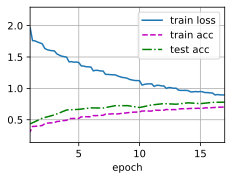

In [ ]:
train_animated(resnet, train_loader_aug, val_loader, num_epochs=17, lr=5e-5)

In [ ]:
torch.save(resnet.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/resnet_flowers.pth')

#### Confusion Matrix

##### Evaluate

In [ ]:
# Recall the model
import torch
# Define the path to the saved model file
model_path = "/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/googlenet_flowers.pth"

# Load the saved state dictionary into the model
net.load_state_dict(torch.load(model_path))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_print_confusion_matrix(net, data_iter, classes, device=None):
    """Compute the confusion matrix for a model on a dataset using a GPU and print it"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    y_true = []
    y_pred = []
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        y_true += y.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

    # Compute the evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    return y_true,y_pred


In [ ]:
classes = df_test.labels.unique()
classes

array(['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid',
       'Poppy', 'Rose', 'Sunflower'], dtype=object)

Accuracy: 0.7909
Precision: 0.8014
Recall: 0.7909
F1-score: 0.7903


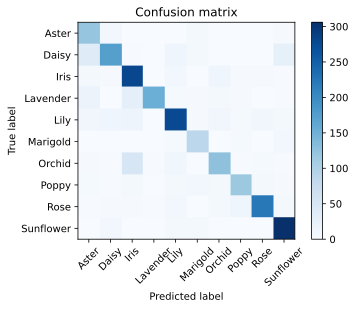

In [ ]:
test_dataset = MyDataset(test_image_path, test_image_label, data_transforms['valid'])
test_loader = DataLoader(test_dataset, num_workers=0, shuffle=True, batch_size=16)
y_true, y_pred = evaluate_and_print_confusion_matrix(resnet, test_loader, classes, device=None)

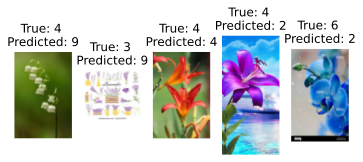

In [ ]:
# convert the lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# find the indices of incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# select a few of these images to display
num_images_to_display = 5
selected_indices = np.random.choice(incorrect_indices, num_images_to_display, replace=False)

# display the selected images
for i, index in enumerate(selected_indices):
    img = Image.open(test_image_path[index])
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.title("True: %s \nPredicted: %s" % (test_image_label[index], y_pred[index]))
    plt.axis('off')

# Birds Classification

## Analysis of Birds Dataset

In order to understand which and how many classes choose for the classification task we analyse how classes are distributed.

In [ ]:
# Import the CSV file as a pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/birds.csv')
# Split the data into three separate DataFrames based on the train/test/validation column
train_data = df.loc[df['data set'] == 'train']
test_data = df.loc[df['data set'] == 'test']
val_data = df.loc[df['data set'] == 'valid']

# Print the number of rows in each DataFrame to verify the split
print("Number of rows in train_data: ", len(train_data))
print("Number of rows in test_data: ", len(test_data))
print("Number of rows in val_data: ", len(val_data))

Number of rows in train_data:  80085
Number of rows in test_data:  2500
Number of rows in val_data:  2500


In [ ]:
# Use value_counts() to count the frequency of each class
class_freq = train_data['labels'].value_counts()

# Create a new dataframe with the frequency for each class
freq_df = pd.DataFrame({'labels': class_freq.index, 'Frequency': class_freq.values})

# Use the describe() function to get a summary of the frequency for each class
freq_summary = freq_df['Frequency'].describe()

# Print the summary statistics
print(freq_summary)

count    500.000000
mean     160.170000
std       19.618636
min      130.000000
25%      149.000000
50%      157.000000
75%      166.000000
max      248.000000
Name: Frequency, dtype: float64


In [ ]:
# Create a new DataFrame with only the classes that have between 170 and 200 images
selected_classes = freq_df.loc[(freq_df['Frequency'] > 170) & (freq_df['Frequency'] < 200), 'labels'].unique()

# Randomly select 25 classes from the selected classes
random_classes = random.sample(list(selected_classes), k=25)

# Print the selected classes
print(len(random_classes))
print(random_classes)

25
['WRENTIT', 'PALM NUT VULTURE', 'RED SHOULDERED HAWK', 'SAYS PHOEBE', 'PARADISE TANAGER', 'WILLOW PTARMIGAN', 'BREWERS BLACKBIRD', 'WALL CREAPER', 'SNOW GOOSE', 'ABBOTTS BOOBY', 'VARIED THRUSH', 'TAWNY FROGMOUTH', 'CRESTED SERPENT EAGLE', 'RUBY CROWNED KINGLET', 'RAZORBILL', 'BLUE MALKOHA', 'BANDED BROADBILL', 'COMMON GRACKLE', 'ASHY STORM PETREL', 'HARPY EAGLE', 'BROWN HEADED COWBIRD', 'PYGMY KINGFISHER', 'LITTLE AUK', 'CEDAR WAXWING', 'NORTHERN BEARDLESS TYRANNULET']


In [ ]:
# Filter the test DataFrame to only include rows where the class is in the randomly selected classes
train_df = train_data[train_data['labels'].isin(random_classes)]

# Filter the validation DataFrame to only include rows where the class is in the randomly selected classes
test_data = test_data[test_data['labels'].isin(random_classes)]

In [ ]:
# Print results
print(test_data.head())

       class id                 filepaths         labels data set  \
80090         1  test/ABBOTTS BOOBY/1.jpg  ABBOTTS BOOBY     test   
80091         1  test/ABBOTTS BOOBY/2.jpg  ABBOTTS BOOBY     test   
80092         1  test/ABBOTTS BOOBY/3.jpg  ABBOTTS BOOBY     test   
80093         1  test/ABBOTTS BOOBY/4.jpg  ABBOTTS BOOBY     test   
80094         1  test/ABBOTTS BOOBY/5.jpg  ABBOTTS BOOBY     test   

        scientific name  
80090  Papasula abbotti  
80091  Papasula abbotti  
80092  Papasula abbotti  
80093  Papasula abbotti  
80094  Papasula abbotti  


## Import the dataset

We noted that the validation and testing folders have only 5 images for class, therfore we decided to merge these folders and then split again in training, validation and testing.

In [ ]:
# Define the paths to the source and destination folders
train_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/birds_folders/train'
valid_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/birds_folders/test'
test_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/birds_folders/valid'
merge_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/birds_folders/all'

# Merge the contents of the training folder for each class
for class_name in os.listdir(train_path):
    class_path = os.path.join(merge_path, class_name)
    if not os.path.exists(class_path):
        os.makedirs(class_path)
        class_train_path = os.path.join(train_path, class_name)
        for file in os.listdir(class_train_path):
            file_path = os.path.join(class_train_path, file)
            shutil.copy(file_path, class_path)
    else:
        print(f"Folder {class_name} already exists. Skipping merging files from {train_path}/{class_name}.")

# Merge the contents of the validation folder for each class
for class_name in os.listdir(valid_path):
    class_path = os.path.join(merge_path, class_name)
    if not os.path.exists(class_path):
        os.makedirs(class_path)
        class_valid_path = os.path.join(valid_path, class_name)
        for file in os.listdir(class_valid_path):
            file_path = os.path.join(class_valid_path, file)
            shutil.copy(file_path, class_path)
    else:
        print(f"Folder {class_name} already exists. Skipping merging files from {valid_path}/{class_name}.")

# Merge the contents of the test folder for each class
for class_name in os.listdir(test_path):
    class_path = os.path.join(merge_path, class_name)
    if not os.path.exists(class_path):
        os.makedirs(class_path)
        class_test_path = os.path.join(test_path, class_name)
        for file in os.listdir(class_test_path):
            file_path = os.path.join(class_test_path, file)
            shutil.copy(file_path, class_path)
    else:
        print(f"Folder {class_name} already exists. Skipping merging files from {test_path}/{class_name}.")


In [ ]:
root_train = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/birds_folders/all'
birds_dirs = os.listdir(root_train)

In [ ]:
#Create a list of birds' types
class_bird = [cla for cla in os.listdir(root_train) if os.path.isdir(os.path.join(root_train, cla))]
print(class_bird)

['WRENTIT', 'WILLOW PTARMIGAN', 'VARIED THRUSH', 'WALL CREAPER', 'SAYS PHOEBE', 'TAWNY FROGMOUTH', 'SNOW GOOSE', 'RAZORBILL', 'RED SHOULDERED HAWK', 'PYGMY KINGFISHER', 'RUBY CROWNED KINGLET', 'PARADISE TANAGER', 'NORTHERN BEARDLESS TYRANNULET', 'LITTLE AUK', 'PALM NUT VULTURE', 'HARPY EAGLE', 'CRESTED SERPENT EAGLE', 'BLUE MALKOHA', 'BROWN HEADED COWBIRD', 'CEDAR WAXWING', 'BREWERS BLACKBIRD', 'COMMON GRACKLE', 'BANDED BROADBILL', 'ASHY STORM PETREL', 'ABBOTTS BOOBY']


In [ ]:
#Create a dictionary containing birds' type and their number class
class_indic = {k: v for v, k in enumerate(class_bird)}
class_indic

{'WRENTIT': 0,
 'WILLOW PTARMIGAN': 1,
 'VARIED THRUSH': 2,
 'WALL CREAPER': 3,
 'SAYS PHOEBE': 4,
 'TAWNY FROGMOUTH': 5,
 'SNOW GOOSE': 6,
 'RAZORBILL': 7,
 'RED SHOULDERED HAWK': 8,
 'PYGMY KINGFISHER': 9,
 'RUBY CROWNED KINGLET': 10,
 'PARADISE TANAGER': 11,
 'NORTHERN BEARDLESS TYRANNULET': 12,
 'LITTLE AUK': 13,
 'PALM NUT VULTURE': 14,
 'HARPY EAGLE': 15,
 'CRESTED SERPENT EAGLE': 16,
 'BLUE MALKOHA': 17,
 'BROWN HEADED COWBIRD': 18,
 'CEDAR WAXWING': 19,
 'BREWERS BLACKBIRD': 20,
 'COMMON GRACKLE': 21,
 'BANDED BROADBILL': 22,
 'ASHY STORM PETREL': 23,
 'ABBOTTS BOOBY': 24}

In [ ]:
#Create a json file containg birds' type
json_str = json.dumps({v: k for k, v in class_indic.items()}, indent=4)
with open('classes_indic_training.json', 'w') as json_file:
    json_file.write(json_str)

In [ ]:
every_class_num = []
supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

# Lists containg information of paths, labels and bad images for Training
filepaths_train = []
labels_train = []
bad_images_train = []
for klass in class_bird:
  classpath = os.path.join(root_train, klass)
  images = [os.path.join(root_train, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] in supported]
  every_class_num.append(len(images))
  flist = sorted(os.listdir(classpath))
  desc = f'{klass:23s}'
  for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(classpath, f)
      fl = f.lower()
      index = fl.rfind('.')
      ext = fl[index:]
      if ext in supported:
          image = Image.open(fpath)
          if image.mode == 'RGB':
              try:
                  img = cv2.imread(fpath)
                  filepaths_train.append(fpath)
                  labels_train.append(klass)
              except:
                  bad_images_train.append(fpath)
                  print('defective image file: ', fpath)
      else:
          bad_images_train.append(fpath)

ABBOTTS BOOBY          : 100%|███████████████████████████████████████████| 185/185 [00:00<00:00, 222.44file/s]


In [ ]:
Fseries = pd.Series(filepaths_train, name='filepaths')
Lseries = pd.Series(labels_train, name='labels')
df_train = pd.concat([Fseries, Lseries], axis=1)
print(f'{len(df_train.labels.unique())} kind of images were found in the dataset')

25 kind of images were found in the dataset


In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and test sets
train_data, test_data = train_test_split(df_train, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Print the number of samples in each set
print(f'Training set: {len(train_data)} samples')
print(f'Validation set: {len(valid_data)} samples')
print(f'Test set: {len(test_data)} samples')

Training set: 3021 samples
Validation set: 756 samples
Test set: 945 samples


In [ ]:
train_image_path = train_data['filepaths'].tolist()
train_image_label = [class_indic[i] for i in train_data['labels'].tolist()]

sample_df = train_data.sample(n=50, replace=False)

ht, wt, count = 0, 0, 0
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
        img = cv2.imread(fpath)
        h = img.shape[0]
        w = img.shape[1]
        ht += h
        wt += w
        count += 1
    except:
        pass
have = int(ht / count)
wave = int(wt / count)
aspect_ratio = have / wave
print('{} images were found in the dataset.\n{} for training'.format(
    sum(every_class_num), len(train_image_path)
))
print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)

4722 images were found in the dataset.
3021 for training
average image height=  224   average image width=  224  aspect ratio h/w=  1.0


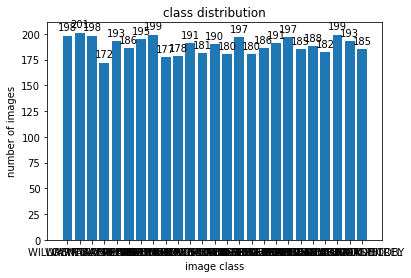

In [ ]:
plt.bar(range(len(class_bird)), every_class_num, align='center')
plt.xticks(range(len(class_bird)), class_bird)

for i, v in enumerate(every_class_num):
    plt.text(x=i, y=v + 5, s=str(v), ha='center')

plt.xlabel('image class')
plt.ylabel('number of images')

plt.title('class distribution')
plt.show()

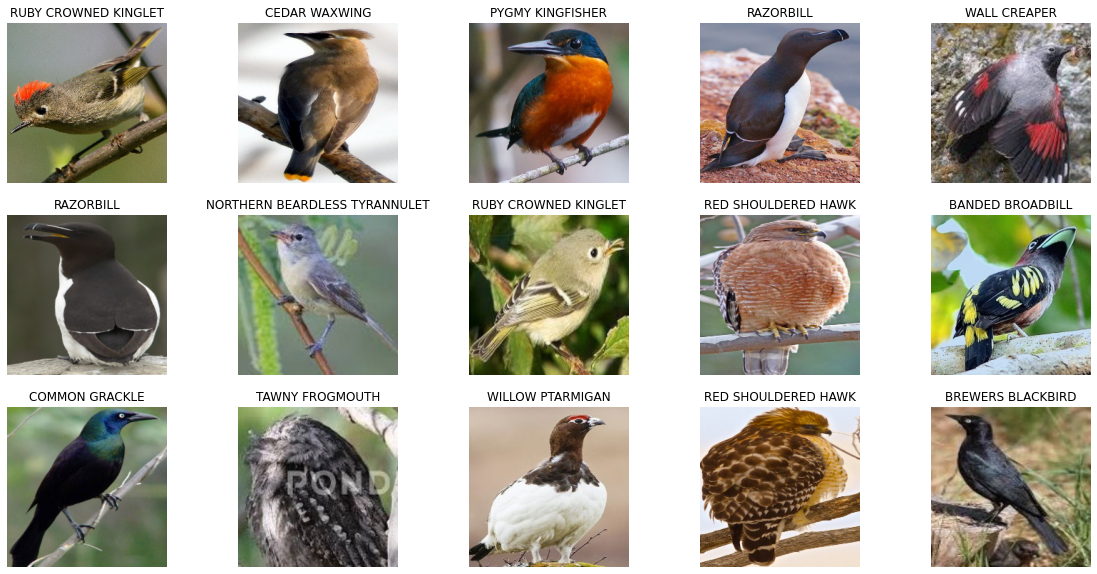

In [ ]:
# Randomly select 15 rows from the dataframe
selected_rows = train_data.sample(n=15, random_state=29)

# Create a Matplotlib figure with 5 subplots
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

# Loop over the selected rows and display each image in a subplot
n=0
for i, row in selected_rows.iterrows():
    img = plt.imread(row['filepaths'])
    ax = axs[n // 5, n % 5]
    ax.imshow(img)
    ax.set_title(row['labels'])
    ax.axis('off')
    n+=1
    if n ==15:
      break

# Show the figure
plt.show()

## Neural Network

### Augmentation
Data augmentation techniques can be used to increase the size of the dataset and improve the performance of the model.
*   Random Crop: Randomly crop the image to a smaller size to simulate the presence of different views of the same flower.
*   Horizontal Flip: Flip the image horizontally to simulate the presence of mirror images of the flower.
*   Random Rotation: Rotate the image by a random angle to simulate the presence of flowers in different orientations.
*   Random Brightness and Contrast: Adjust the brightness and contrast of the image by a random factor to simulate the presence of flowers under different lighting conditions.
*   Color Jitter: Randomly adjust the hue, saturation, and brightness of the image to simulate the presence of flowers with different colors. (we removed it after the accuracy of the model decreased from 69% to 53%)









In [ ]:
batch_size = 32

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_1'])
train_loader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=batch_size)

In [ ]:
mean, std = get_mean_std(train_loader)

In [ ]:
norm_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])


norm_train_dataset = ImageFolder(root_train, transform=norm_image_transforms)

norm_train_dataloader = data.DataLoader(norm_train_dataset,batch_size=batch_size,shuffle=True)

labels: tensor([ 7, 22, 23, 19, 11,  5,  0, 10,  5, 11, 14, 14, 15,  4,  5])


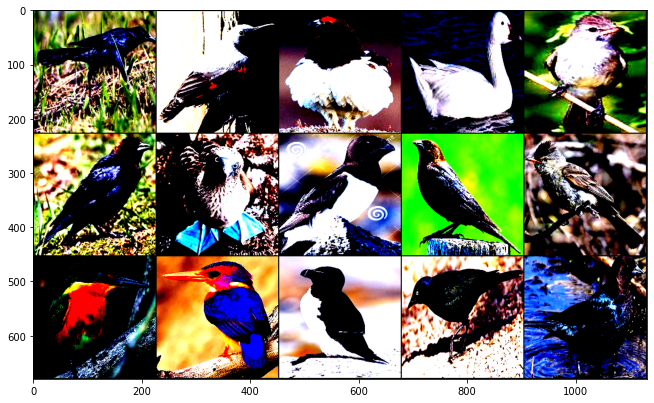

In [ ]:
show_images(norm_train_dataset)

In [ ]:
print(torch.Tensor(mean), torch.Tensor(std))

tensor([0.4760, 0.4750, 0.4195]) tensor([0.2072, 0.2071, 0.2119])


In [ ]:
import torchvision.transforms.functional as TF
class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, image):
        h, w = image.shape[1], image.shape[2]

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(image)

        image = image * mask

        return image
class RandomAdjustSharpness:
    def __init__(self, sharpness_range=(0, 1), p=0.5):
        self.sharpness_range = sharpness_range
        self.p = p

    def __call__(self, x):
        if random.random() < self.p:
            sharpness_factor = random.uniform(*self.sharpness_range)
            return TF.adjust_sharpness(x, sharpness_factor)
        return x

In [ ]:
data_transforms = {
    'train_1': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
    ]),
    'train_2': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        #transforms.GaussianBlur(kernel_size=3),
        #transforms.RandomErasing(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.4760, 0.4750, 0.4195],[0.2072, 0.2071, 0.2119]),
    ]),
    'train_3': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.4760, 0.4750, 0.4195],[0.2072, 0.2071, 0.2119]),
    ]),
    'train_4': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.4760, 0.4750, 0.4195],[0.2072, 0.2071, 0.2119]),
    ]),
    'train_5': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.2, hue=0.5),
        transforms.RandomRotation(70),
        transforms.ToTensor(),
        transforms.Normalize([0.4760, 0.4750, 0.4195],[0.2072, 0.2071, 0.2119]),
    ]),
    'train_6': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.4760, 0.4750, 0.4195],[0.2072, 0.2071, 0.2119]),
    ]),
    'train_7': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.9, hue=0.4),
        transforms.ToTensor(),
        transforms.Normalize([0.4760, 0.4750, 0.4195],[0.2072, 0.2071, 0.2119]),
    ]),
    'train_8': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=70),
    ]),
    'train_9': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=126),
    ]),
    'train_10': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=126),
    ]),
    'train_11': transforms.Compose([
        transforms.CenterCrop(256),
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=126),
    ]),
    'train_12': transforms.Compose([
        transforms.CenterCrop(120),
        transforms.Resize([224, 224]),
        RandomAdjustSharpness(sharpness_range=(0, 1), p=0.9),
        transforms.ToTensor(),
        Cutout(n_holes=1, length=23),
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.4760, 0.4750, 0.4195],[0.2072, 0.2071, 0.2119]),
    ])
}


#### Augmentation applied

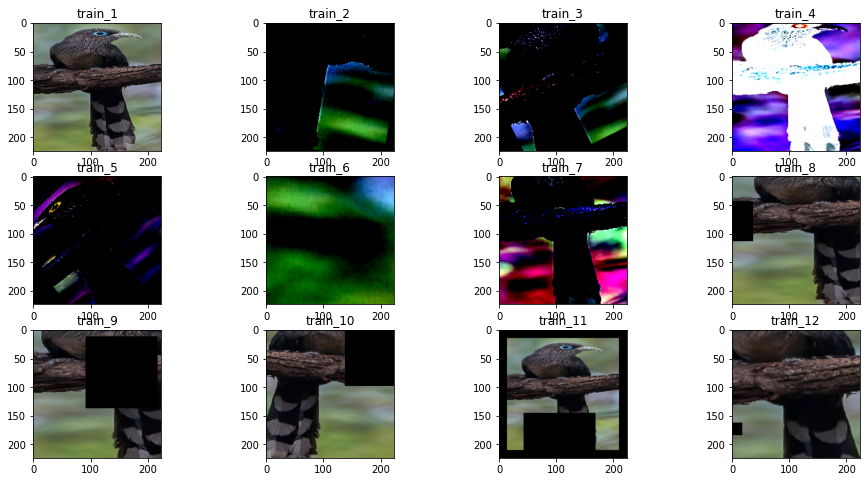

In [ ]:
# Load an image
img_path = '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/birds_folders/all/BLUE MALKOHA/004.jpg'
img = Image.open(img_path)

fig, axs = plt.subplots(3, 4, figsize=(16, 8))
for i, key in enumerate(data_transforms.keys()):
    if key.startswith('train_'):
        row = i // 4
        col = i % 4
        transformed_img = data_transforms[key](img)
        axs[row][col].imshow(transformed_img.permute(1, 2, 0))
        axs[row][col].set_title(key)
plt.show()

In [ ]:
batch_size = 32

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_1'])
train_loader = DataLoader(train_dataset, num_workers=0, shuffle=True, batch_size=batch_size)
train_num = len(train_dataset)

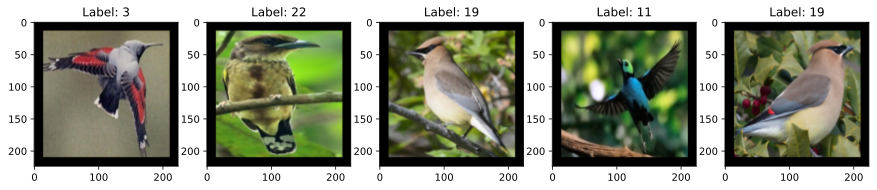

In [ ]:
# Get a batch of images from the DataLoader
images, labels = next(iter(train_loader))

# Display the first 5 images from the batch
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(images[i].permute(1, 2, 0))
    ax[i].set_title(f"Label: {labels[i]}")
plt.show()

### GoogleNet

#### Create the Neural Network

In [ ]:
from torch.nn import functional as F
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): #192, 64, (96, 128), (16, 32), 32)
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [ ]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)), # The argument (1,1) is the required OUTPUT shape
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Dropout(0.8), nn.Linear(1024, 25))

#### Tuning the Learning Rate

Tuning the learning rate is an important step in deep learning to ensure that the model converges quickly and effectively during training. The learning rate is a hyperparameter that determines how much the model should adjust its weights during training. It determines the size of the step that the optimizer takes at each iteration while searching for the optimal weights.

We star with 5 values for learning rate, respectively **1e-7, 1e-6, 7e-5, 5e-5, 3e-5, 1e-5** and peferm GoogleNet in K-Fold with:


*   num_epochs = 2
*   batch_size = 8
*   k = 5



In [ ]:
list_lr = [1e-7, 1e-6, 7e-5, 5e-5, 3e-5, 1e-5]
for i in list_lr:
  print('-------------------\n')
  print('Learning rate = {}'.format(i))
  k_fold_cross_validation(train_dataset, net, i, num_epochs=2, batch_size=8, k=5)

-------------------

Learning rate = 1e-07
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.46s/it]


Fold [1/5]: Accuracy = 3.03%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.43s/it]


Fold [2/5]: Accuracy = 3.03%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.31s/it]


Fold [3/5]: Accuracy = 2.93%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.13s/it]


Fold [4/5]: Accuracy = 4.12%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.38s/it]


Fold [5/5]: Accuracy = 4.12%
Average Accuracy = 3.44%
-------------------

Learning rate = 1e-06
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.67s/it]


Fold [1/5]: Accuracy = 3.03%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.49s/it]


Fold [2/5]: Accuracy = 4.65%
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.80s/it]


Fold [3/5]: Accuracy = 3.90%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.41s/it]


Fold [4/5]: Accuracy = 4.12%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.44s/it]


Fold [5/5]: Accuracy = 5.09%
Average Accuracy = 4.16%
-------------------

Learning rate = 7e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.24s/it]


Fold [1/5]: Accuracy = 3.68%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.21s/it]


Fold [2/5]: Accuracy = 7.58%
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.69s/it]


Fold [3/5]: Accuracy = 11.38%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.34s/it]


Fold [4/5]: Accuracy = 10.94%
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.82s/it]


Fold [5/5]: Accuracy = 3.25%
Average Accuracy = 7.36%
-------------------

Learning rate = 5e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.61s/it]


Fold [1/5]: Accuracy = 7.25%
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.58s/it]


Fold [2/5]: Accuracy = 11.90%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.26s/it]


Fold [3/5]: Accuracy = 12.68%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.42s/it]


Fold [4/5]: Accuracy = 16.03%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.33s/it]


Fold [5/5]: Accuracy = 11.38%
Average Accuracy = 11.85%
-------------------

Learning rate = 3e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.87s/it]


Fold [1/5]: Accuracy = 7.90%
training on cuda:0


Training: 100%|██████████| 2/2 [01:11<00:00, 35.70s/it]


Fold [2/5]: Accuracy = 14.83%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.11s/it]


Fold [3/5]: Accuracy = 9.32%
training on cuda:0


Training: 100%|██████████| 2/2 [01:09<00:00, 34.98s/it]


Fold [4/5]: Accuracy = 16.58%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.11s/it]


Fold [5/5]: Accuracy = 12.57%
Average Accuracy = 12.24%
-------------------

Learning rate = 1e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.28s/it]


Fold [1/5]: Accuracy = 7.03%
training on cuda:0


Training: 100%|██████████| 2/2 [01:09<00:00, 34.91s/it]


Fold [2/5]: Accuracy = 8.55%
training on cuda:0


Training: 100%|██████████| 2/2 [01:10<00:00, 35.09s/it]


Fold [3/5]: Accuracy = 6.72%
training on cuda:0


Training: 100%|██████████| 2/2 [01:09<00:00, 34.73s/it]


Fold [4/5]: Accuracy = 7.69%
training on cuda:0


Training: 100%|██████████| 2/2 [01:09<00:00, 34.91s/it]


Fold [5/5]: Accuracy = 7.69%
Average Accuracy = 7.54%


GoogleNet performe very bad, probably because it has a large number of parameters, which requires a lot of training data to avoid overfitting.

**Some Conclusions**

Before to proceed using other model we tried to modify and increase the size of the dataset using data augmentation techniques, but I was not possible to see improvement in accuracy classification, the model led always in overfitting.

For this reason we decide to implement a different model, like ResNet18.


### ResNet - 18

#### Create the Neural Network

In [ ]:
# Define the ResNet block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.stride = stride

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes=25):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            ResNetBlock(64, 64),
            ResNetBlock(64, 64)
        )
        self.layer2 = nn.Sequential(
            ResNetBlock(64, 128, stride=2),
            ResNetBlock(128, 128)
        )
        self.layer3 = nn.Sequential(
            ResNetBlock(128, 256, stride=2),
            ResNetBlock(256, 256)
        )
        self.layer4 = nn.Sequential(
            ResNetBlock(256, 512, stride=2),
            ResNetBlock(512, 512)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

#### Tuning the Learning Rate

In [ ]:
# Define the ResNet model
resnet = ResNet(num_classes=25)

In [ ]:
list_lr = [5e-5, 3e-5, 1e-5]
for i in list_lr:
  print('-------------------\n')
  print('Learning rate = {}'.format(i))
  k_fold_cross_validation(train_dataset, resnet, i, num_epochs=2, batch_size=8, k=5)

-------------------

Learning rate = 5e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:14<00:00, 37.18s/it]


Fold [1/5]: Accuracy = 49.13%
training on cuda:0


Training: 100%|██████████| 2/2 [01:05<00:00, 32.98s/it]


Fold [2/5]: Accuracy = 49.78%
training on cuda:0


Training: 100%|██████████| 2/2 [01:05<00:00, 32.84s/it]


Fold [3/5]: Accuracy = 50.92%
training on cuda:0


Training: 100%|██████████| 2/2 [01:05<00:00, 32.92s/it]


Fold [4/5]: Accuracy = 48.65%
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.23s/it]


Fold [5/5]: Accuracy = 49.84%
Average Accuracy = 49.66%
-------------------

Learning rate = 3e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.14s/it]


Fold [1/5]: Accuracy = 47.40%
training on cuda:0


Training: 100%|██████████| 2/2 [01:05<00:00, 32.99s/it]


Fold [2/5]: Accuracy = 50.11%
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.34s/it]


Fold [3/5]: Accuracy = 44.42%
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.39s/it]


Fold [4/5]: Accuracy = 42.36%
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.33s/it]


Fold [5/5]: Accuracy = 43.34%
Average Accuracy = 45.53%
-------------------

Learning rate = 1e-05
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.17s/it]


Fold [1/5]: Accuracy = 38.42%
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.30s/it]


Fold [2/5]: Accuracy = 35.93%
training on cuda:0


Training: 100%|██████████| 2/2 [01:06<00:00, 33.05s/it]


Fold [3/5]: Accuracy = 35.97%
training on cuda:0


Training: 100%|██████████| 2/2 [01:07<00:00, 33.53s/it]


Fold [4/5]: Accuracy = 38.03%
training on cuda:0


Training: 100%|██████████| 2/2 [01:07<00:00, 33.62s/it]


Fold [5/5]: Accuracy = 38.14%
Average Accuracy = 37.30%


### Import the Validation Data

In [ ]:
validation_image_path = valid_data['filepaths'].tolist()
validation_image_label = [class_indic[i] for i in valid_data['labels'].tolist()]

In [ ]:
def train_animated(net, train_iter, test_iter, num_epochs, lr,
          device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr,  weight_decay=0.001)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in tqdm(range(num_epochs), desc='Training', colour='blue'):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()

            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, test acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

### ResNet18 with Augmentation

In [ ]:
Aug = []

batch_size = 64*2

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_1'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_3'])
Aug.append(train_dataset)
#----
train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_9'])
Aug.append(train_dataset)

train_dataset = MyDataset(train_image_path, train_image_label, data_transforms['train_12'])
Aug.append(train_dataset)

In [ ]:
val_dataset = MyDataset(validation_image_path, validation_image_label, data_transforms['test'])
val_loader = DataLoader(val_dataset, num_workers=0, shuffle=True, batch_size=batch_size)

In [ ]:
train_dataset_aug = torch.utils.data.ConcatDataset(Aug)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

Training: 100%|██████████| 20/20 [19:23<00:00, 58.19s/it]

loss 1.004, test acc 0.706, test acc 0.581
352.2 examples/sec on cuda:0


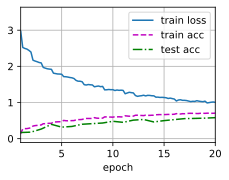

In [ ]:
train_animated(resnet, train_loader_aug, val_loader, num_epochs=20, lr=5e-5)

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/Deep Learning for AI Project/resnet_birds.pth')

#### Confusion Matrix

##### Import Test

In [ ]:
test_image_path = test_data['filepaths'].tolist()
test_image_label = [class_indic[i] for i in test_data['labels'].tolist()]

##### Evaluate

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_print_confusion_matrix(net, data_iter, classes, device=None):
    """Compute the confusion matrix for a model on a dataset using a GPU and print it"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    y_true = []
    y_pred = []
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        y_true += y.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

    # Compute the evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    return y_true,y_pred


In [ ]:
classes = test_data.labels.unique()
classes

array(['BLUE MALKOHA', 'PYGMY KINGFISHER', 'TAWNY FROGMOUTH',
       'CEDAR WAXWING', 'RED SHOULDERED HAWK', 'LITTLE AUK',
       'BANDED BROADBILL', 'CRESTED SERPENT EAGLE', 'SNOW GOOSE',
       'BROWN HEADED COWBIRD', 'VARIED THRUSH', 'WALL CREAPER',
       'ABBOTTS BOOBY', 'WILLOW PTARMIGAN', 'SAYS PHOEBE',
       'RUBY CROWNED KINGLET', 'NORTHERN BEARDLESS TYRANNULET',
       'RAZORBILL', 'PALM NUT VULTURE', 'BREWERS BLACKBIRD', 'WRENTIT',
       'COMMON GRACKLE', 'HARPY EAGLE', 'PARADISE TANAGER',
       'ASHY STORM PETREL'], dtype=object)

Accuracy: 0.6011
Precision: 0.6471
Recall: 0.6011
F1-score: 0.6008


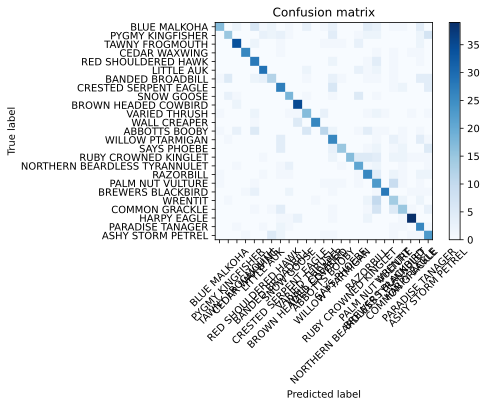

In [ ]:
test_dataset = MyDataset(test_image_path, test_image_label, data_transforms['test'])
test_loader = DataLoader(test_dataset, num_workers=0, shuffle=True, batch_size=16)
y_true, y_pred = evaluate_and_print_confusion_matrix(resnet, test_loader, classes, device=None)

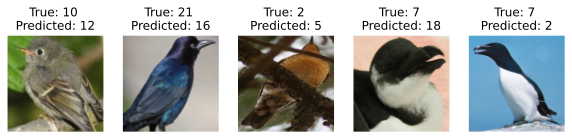

In [ ]:
# convert the lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# find the indices of incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

selected_indices = np.random.choice(incorrect_indices, num_images_to_display, replace=False)

# Set the size of the displayed images
fig_width = 10
fig_height = 5

# Display the selected images
num_images_to_display = 5
fig, axs = plt.subplots(1, num_images_to_display, figsize=(fig_width, fig_height))
for i, index in enumerate(selected_indices):
    img = Image.open(test_image_path[index])
    axs[i].imshow(img)
    axs[i].set_title("True: %s \nPredicted: %s" % (test_image_label[index], y_pred[index]))
    axs[i].axis('off')
plt.show()

# Final Conclusions

After conducting experiments with both GoogleNet and ResNet-18 architectures on our datasets, we compared the performance of both models based on their accuracy scores. We found that the ResNet-18 model achieved higher accuracy than the GoogleNet model, which indicates that it is a better model for our specific task.

Furthermore, we can also compare the complexity of both models. ResNet-18 has a simpler architecture than GoogleNet, which means it may be easier and faster to train. This is a significant advantage when working with large datasets, as it can reduce the amount of time and computational resources required to train the model.

Overall, based on our experiments and evaluation, we conclude that the ResNet-18 model is the better model for our task of image classification. It achieved higher accuracy than GoogleNet while also being simpler to train.